In [1]:
import condo
import numpy as np
import matplotlib.pyplot as plt
import ot
import pandas as pd
import seaborn as sns
import sklearn
import time
import warnings

from matplotlib.colors import LogNorm

In [2]:
N_T = 100
N_S = 100

# How confounder X affects the distribution of T and S
mu_hotdog = 5.
sigma_hotdog = 1.0
mu_not = 0.0
sigma_not = 2.0

# How batch effect affects S
batch_m = 2
batch_b = 5
# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

In [3]:
n_hotdogT = 75 
n_notT = 25
n_hotdogS = 25
n_notS = 75
X_T = np.array([['hotdog']*n_hotdogT + ['not']*n_notT]).reshape((N_T, 1))
X_S = np.array([['hotdog']*n_hotdogS + ['not']*n_notS]).reshape((N_S, 1))

In [4]:
Strue = np.nan * np.ones((N_S, 1))
T = np.nan * np.ones((N_T, 1))
Strue[np.where(X_S[:,0] == 'hotdog'), 0] = np.random.normal(
    mu_hotdog, sigma_hotdog, size=(n_hotdogS))
T[np.where(X_T[:,0] == 'hotdog'), 0] = np.random.normal(
    mu_hotdog, sigma_hotdog, size=(n_hotdogT))
Strue[np.where(X_S[:,0] == 'not'), 0] = np.random.normal(
    mu_not, sigma_not, size=(n_notS))
T[np.where(X_T[:,0] == 'not'), 0] = np.random.normal(
    mu_not, sigma_not, size=(n_notT))

Sbatch = batch_m * Strue + batch_b

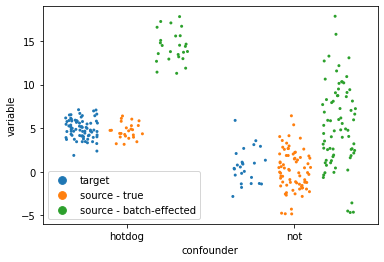

In [5]:
dfT = pd.concat([
    pd.DataFrame(T, columns=['variable']), pd.DataFrame(X_T, columns=['confounder'])
], axis=1)
dfT["batch"] = "target"
dfStrue = pd.concat([
    pd.DataFrame(Strue, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfStrue["batch"] = "source - true"
dfSbatch = pd.concat([
    pd.DataFrame(Sbatch, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSbatch["batch"] = "source - batch-effected"

df = pd.concat([dfT, dfStrue, dfSbatch], axis=0)
sns.stripplot(
    x="confounder",
    y="variable",
    hue="batch",
    jitter=0.3,
    dodge=True,
    s=3,
    data=df)
plt.legend(loc='best', title='');

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        divergence="reverse",
        model_type="linear",
        #optim_kwargs={"epochs": 100, "alpha": 1e-4, "beta": 0.9},
        debug=True,
        verbose=1
    )
    cder.fit(Sbatch, T, X_S, X_T)
    Sadapted = cder.transform(Sbatch)
    
lter = ot.da.LinearTransport()
lter.fit(Xs=Sbatch, Xt=T)
Slinear = lter.transform(Xs=Sbatch)

A non-descent direction was encountered.
         Current function value: -6.247104
         Iterations: 14
         Function evaluations: 15


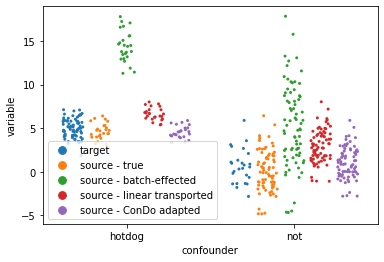

In [7]:
dfSadapted = pd.concat([
    pd.DataFrame(Sadapted, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSadapted["batch"] = "source - ConDo adapted"

dfSlinear = pd.concat([
    pd.DataFrame(Slinear, columns=['variable']), pd.DataFrame(X_S, columns=['confounder'])
], axis=1)
dfSlinear["batch"] = "source - linear transported"

df = pd.concat([dfT, dfStrue, dfSbatch, dfSlinear, dfSadapted], axis=0)
sns.stripplot(
    x="confounder",
    y="variable",
    hue="batch",
    jitter=0.3,
    dodge=True,
    s=3,
    data=df)
plt.legend(loc='best', title='');

In [8]:
print(batch_m, batch_b)
print(true_m, true_b)
print(cder.M_, cder.b_)
print((lter.A_, lter.B_))

2 5
0.5 -2.5
[[0.38640204]] [-1.00083411]
(array([[0.40483844]]), array([[0.80171005]]))


In [9]:
print(np.sqrt(np.mean((Strue - Slinear) ** 2)))
print(np.sqrt(np.mean((Strue - Sadapted) ** 2)))

2.637699480927881
0.9082442693645781


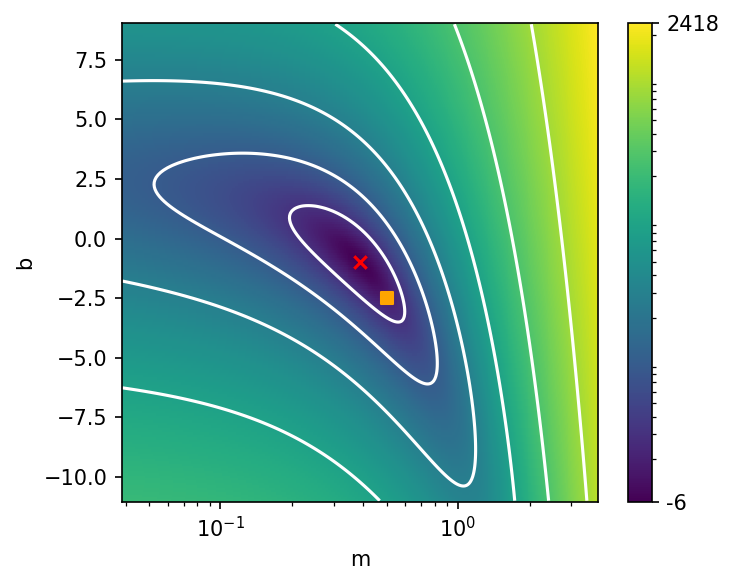

In [10]:
plt.figure(figsize=(5,4), dpi=150)
color_vals = cder.debug_dict_["mb_objs"] + 1 - np.min(cder.debug_dict_["mb_objs"])
plt.pcolormesh(
    cder.debug_dict_["m_plot"], cder.debug_dict_["b_plot"], color_vals.T,
    norm=LogNorm(vmin=color_vals.min(), vmax=color_vals.max())
);
plt.xscale('log');

cbar = plt.colorbar();
cbar.ax.get_yaxis().set_ticks([color_vals.min(), color_vals.max()]);
cbar.ax.get_yaxis().set_ticklabels(
    [int(np.round(cder.debug_dict_["mb_objs"].min())), int(np.round(cder.debug_dict_["mb_objs"].max()))]);
cont = plt.contour(
    cder.debug_dict_["m_plot"], cder.debug_dict_["b_plot"], color_vals.T, 
    levels=np.geomspace(color_vals.min(), color_vals.max(), 8), colors='white', linestyles='solid');
plt.ylabel('b');
plt.xlabel('m');
plt.scatter(true_m, true_b, marker='s', c='orange');
plt.scatter(cder.M_[0,0], cder.b_[0], marker='x', c='red');
plt.tight_layout();